In [132]:
import numpy as np
import numpy.linalg as npl
import scipy as sp
import scipy.sparse.linalg as spspl
import matplotlib.pyplot as plt
%pylab inline
from dolfin import *

Populating the interactive namespace from numpy and matplotlib


/home/treillou/anaconda3/envs/fenicsproject/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['e', 'info', 'dot', 'split', 'pi', 'inv', 'test', 'norm', 'plot', 'gamma', 'outer', 'inner', 'sin', 'cos', 'det', 'exp', 'sqrt', 'diff', 'shape', 'tan', 'solve', 'cross']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [152]:
args = [1, 10, 6]
np.linspace(*args)

array([ 1. ,  2.8,  4.6,  6.4,  8.2, 10. ])

## Définition des classes et paramètres

In [133]:
# Rayon du disque
r = 0.3

# Nombre de noeuds
N = 50

# Classes des domaines
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0)
class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 1.0)
class Bottom(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)
class Top(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 1.0)
class Gamma0(SubDomain):
    def inside(self, x, on_boundary):
        return (x[1]-0.5)**2<=r**2-(x[0]-0.5)**2 and (x[1]-0.5)**2<=r**2-(x[0]-0.5)**2

# Initialize sub-domain instances
left   = Left()
top    = Top()
right  = Right()
bottom = Bottom()
gamma  = Gamma0()

# Define mesh
mesh = UnitSquareMesh(N,N)

# Initialize mesh function for interior domains
domains = MeshFunction("size_t", mesh, mesh.topology().dim())
domains.set_all(0)         #domains 0 = all space
gamma.mark(domains, 1)     #domains 1 = all gamma0

# Initialize mesh function for boundary domains
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1) #1d domains
boundaries.set_all(0)      #boundaries 0 = all boundaries
left.mark(boundaries, 1)   #boundaries 1 = left (Neumann)
top.mark(boundaries, 2)    #boundaries 2 = top (Dirichlet)
right.mark(boundaries, 3)  #boundaries 3 = right (Neumann)
bottom.mark(boundaries, 4) #boundaries 4 = bottom (Neumann parametrized)

# Define function space and basis functions
V = FunctionSpace(mesh, "CG", 1)
u = TrialFunction(V)
v = TestFunction(V)

# Define Dirichlet boundary conditions at top and bottom boundaries
bcs = [DirichletBC(V, 0.0, boundaries, 2)]

# Define new measures associated with the interior domains and
# exterior boundaries
dx = Measure('dx', domain=mesh, subdomain_data=domains)
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

## Solver du problème 2D

In [134]:
def Solver(mu):
    # Define input data
    mu0 = Constant(mu[0])  
    mu1 = Constant(mu[1])
    
    # Separate left and right hand sides of equation
    a0= inner(grad(u),grad(v))*dx(0)
    def a1(mu0):
        return inner(mu0*grad(u),grad(v))*dx(1)
    a = a0 + a1(mu0) #+ inner(mu1*grad(u),grad(v))*ds(4)
    L0 = v*ds(4)
    L = mu1*L0
    
    # Passage en nd.array
    A = assemble(a)
    b = assemble(L)
    A2 = np.copy(A.array())
    b2 = np.copy(b.get_local())
    
    # Conditions de Dirichlet
    n=0
    niter=2
    for i in range((N+1)**2):
        for j in range((N+1)**2):
            if (i == n)and(i<=int((N+1)**2)/2):
                A2[i,:] = 0
                A2[i,i] = 1
                n += niter
                niter += 1
    
    # Résolution du système linéaire
    u2 = npl.solve(A2,b2)
    
    # Passage en dolfin.Function
    Sol = Function(V)
    Sol.vector().set_local(u2)
    #c = plot(Sol)
    #plt.colorbar(c)

    return np.array([Sol,A2,b2])

In [135]:
mu_test = np.array([0.4,0.1])
A = Solver(mu_test)[0]
print(type(A))

<class 'dolfin.function.function.Function'>


## Offline procedure

In [162]:
def greedy_algorithm(MUs, solver=Solver, tol=1e-5, n=1):
    # On prend un mu (au hasard) pour initialiser l'algorithme
    #mu_1 = MUs[0]
    #np.delete(MUs, 0)
    U_delta_mu1 = solver(MUs[0])[0].vector().get_local()
    
    #U_delta_list = []
    #for mu_loop in training_set:
    #        U_delta_list.append(solver(mu_loop)[0].vector().get_local())
    #        print("itération")
    rang = np.array(np.arange(0,len(MUs),1),'int')
    np.delete(rang,0)
    # On calcule tous les u_delta pour éviter de le refaire dans la boucle par la suite
    U_DELTA = np.array([solver(MUs[i])[0].vector().get_local() for i in rang])
    
    # B est la matrice de changement de base de A_delta à A_rb
    U_delta = np.array(U_delta_mu1)
    B = np.copy(U_delta).reshape(len(U_delta),1)
    
    err = 1e10
    #print(np.shape(U_delta))
    
    while err > tol and rang.shape[0] > 0:
        
        eta = np.zeros(rang.shape[0])
        
        for idx_mu in rang:
            A_delta_mu = solver(MUs[idx_mu])[1]
            f_delta_mu = solver(MUs[idx_mu])[2]
        
            u_delta_mu = U_DELTA[idx_mu]
            
            # A_rb_mu @ u_rb_mu = f_rb_mu
            # A_rb_mu = B.T @ A_delta_mu @ B
            print("A    : ",np.shape(A_delta_mu))
            print("b    : ",np.shape(f_delta_mu))
            print("Base : ",np.shape(B))
            u_rb_mu = npl.solve(B.T.dot(A_delta_mu.dot(B)), B.T.dot(f_delta_mu))
            
            # Pour l'instant, eta(mu) = ||u_delta - u_rb||_L2
            eta[idx_mu] = npl.norm(u_delta_mu - B.dot(u_rb_mu), ord=2)
        
        print("ici")
        # On cherche la pire approximation
        idx_worst_mu = np.argmax(eta)
        
        add = np.array(U_DELTA[idx_worst_mu]).reshape(2601,1).T
        B = np.vstack((B.T,add/npl.norm(add))).T
        
        np.delete(rang, idx_worst_mu)
        np.delete(U_DELTA, idx_worst_mu)
        
        err = eta[idx_worst_mu]
        
    return B

In [163]:
def training_set_creator(*args):
    """
    args are a non-zero number of lists of size 3.
    Example of use: we want the creation of an iteratable representing all possible elements on a n-dimensional grid
    first dimension goes from a to b with c elements, then you pass "[a,b,c]" as a first argument.
    return: n-dimensional grid on which you can iterate.
    
    """
    linspace_args = (np.linspace(*arg) for arg in args)
    
    meshes = np.meshgrid(*linspace_args)
    dimensions = map(np.ravel, meshes)
#     dimensions = [mesh.ravel() for mesh in meshes]
    
    tuples = zip(*dimensions)
    return list(tuples)
#     for tup in tuples:
#         yield(tuple(tup))

In [164]:
def reduced_solver(mu,A_q,shape):
    """
    from output of pre_computer and a mu: computes A_rb and f_rb and u_rb, the solution of A_rb.u_rb=f_rb
    """
    A = np.copy(A_q[1])
    f = np.copy(A_q[3])
    for i in range(shape):
        A += A_q[0][i]*mu[i]
    for i in range(shape,len(mu)):
        f += A_q[2][i-shape]*mu[i]
    return npl.solve(A,f)

## Precomputer

In [165]:
def pre_computer(Base):
    """
    pre_computer take as input a reduced_base and pre_computes all quantities used for a reduced_solver.
    output: [[A_rb^q](0<= i <=n1),A_rb^0,[f_rb^q](0<= i <=n2),f_rb^0],n
    with A_rb = sum_(i in 0..n1){ mu[i]*A_rb^(q_1)_i } + A_rb^0
    and  f_rb = sum_(i in n1+1..n2){ mu[i]*f_rb^(q_1)_i } + f_rb^0
            n = n1+1
    """
    #mu0 = Constant(mu[0])
    #mu1 = Constant(mu[1])
    # Separate left and right hand sides of equation
    a0= inner(grad(u),grad(v))*dx(0)
    #def a1(mu0):
    #    return inner(grad(u),grad(v))*dx(1)
    a1 = inner(grad(u),grad(v))*dx(1)

    L0 = v*ds(4)
    #L = mu1*L0
    
    A_0M = assemble(a0)
    A_1M = assemble(a1)
    b = assemble(L0)
    A_0 = np.copy(A_0M.array())
    A_1 = np.copy(A_1M.array())
    b_0 = np.copy(b.get_local())
    #n=0
    #niter=2
    #for i in range((N+1)**2):
    #    for j in range((N+1)**2):
    #        if (i == n)and(i<=int((N+1)**2)/2):
    #            A_0[i,:] = 0
    #            A_0[i,i] = 1
    #            n += niter
    #            niter += 1
                
    A0B = [Base.T.dot(A_1.dot(Base))]
    A1B = Base.T.dot(A_0.dot(Base))
    b1 = [Base.T.dot(b_0)]
    b2 = Base.T.dot(np.zeros(b_0.shape))
    
    #At = assemble(a0 + a1(mu0))
    #bt = assemble(L)
    #A = np.copy(At.array())
    #b = np.copy(bt.get_local())
    
    return [A0B,A1B,b1,b2],1 #[Base.T.dot(A.dot(Base)),Base.T.dot(b)],1

## Résolution

### Création de la base

In [ ]:
%%timeit
T0 = np.array([1,10,50])
T1 = np.array([-1,1,100])
training_set = training_set_creator(T0,T1)
Base, error = greedy_algorithm(training_set,tol=0.0001)

In [151]:
%%time
T0 = np.array([1,10,10])
T1 = np.array([-1,1,10])
training_set = training_set_creator(T0,T1)
test = np.zeros((10,2))
for i in range(10):
    test[i] = np.copy([0.1 + i*0.99,-1 + i* 0.2])
Base = greedy_algorithm(Solver,test)

A    :  (2601, 2601)
b    :  (2601,)
Base :  (2601, 1)
A    :  (2601, 2601)
b    :  (2601,)
Base :  (2601, 1)
A    :  (2601, 2601)
b    :  (2601,)
Base :  (2601, 1)
A    :  (2601, 2601)
b    :  (2601,)
Base :  (2601, 1)
A    :  (2601, 2601)
b    :  (2601,)
Base :  (2601, 1)
A    :  (2601, 2601)
b    :  (2601,)
Base :  (2601, 1)
A    :  (2601, 2601)
b    :  (2601,)
Base :  (2601, 1)
A    :  (2601, 2601)
b    :  (2601,)
Base :  (2601, 1)
A    :  (2601, 2601)
b    :  (2601,)
Base :  (2601, 1)
A    :  (2601, 2601)
b    :  (2601,)
Base :  (2601, 1)
ici
A    :  (2601, 2601)
b    :  (2601,)
Base :  (2601, 2)
A    :  (2601, 2601)
b    :  (2601,)
Base :  (2601, 2)
A    :  (2601, 2601)
b    :  (2601,)
Base :  (2601, 2)
A    :  (2601, 2601)
b    :  (2601,)
Base :  (2601, 2)
A    :  (2601, 2601)
b    :  (2601,)
Base :  (2601, 2)
A    :  (2601, 2601)
b    :  (2601,)
Base :  (2601, 2)
A    :  (2601, 2601)
b    :  (2601,)
Base :  (2601, 2)
A    :  (2601, 2601)
b    :  (2601,)
Base :  (2601, 2)
A    :

In [141]:
print(np.shape(Base))

(2601, 7)


### Truth solution for mu_test & évaluation du temps mis

In [142]:
mu_test = np.array([10,1])

In [143]:
%%time

U_true = Solver(mu_test)[0]

CPU times: user 2.12 s, sys: 123 ms, total: 2.24 s
Wall time: 1.13 s


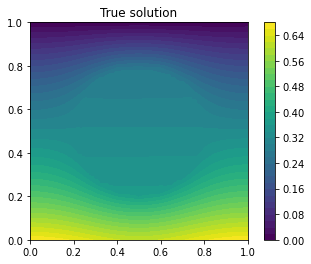

In [35]:
c = plot(U_true)
plt.title("True solution")
plt.colorbar(c)
plt.show()

### Online procedure ne dépendant pas de mu

In [145]:
%%time
A_q,shape = pre_computer(Base)

CPU times: user 209 ms, sys: 95.4 ms, total: 305 ms
Wall time: 195 ms


### Résolution en base réduite & évaluation du temps

In [146]:
%%time
mu_test_rb = np.array([15,0.1])
U_rb = reduced_solver(mu_test_rb,A_q,shape)

CPU times: user 1.4 ms, sys: 86 µs, total: 1.49 ms
Wall time: 6.94 ms


(2601,)


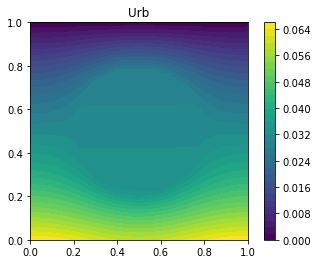

In [147]:
RES = Base.dot(U_rb)
print(np.shape(RES))
urb = Function(V)
urb.vector().set_local(RES)
e = plot(urb)
plt.title('Urb')
plt.colorbar(e)
plt.show()

In [148]:
%%time
U_true = Solver(np.array([15,0.1]))[0]

CPU times: user 1.97 s, sys: 101 ms, total: 2.07 s
Wall time: 1.03 s


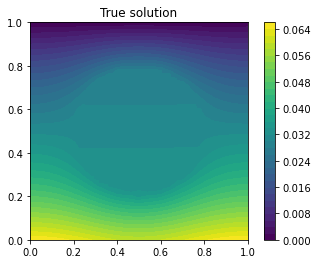

In [149]:
c = plot(U_true)
plt.title("True solution")
plt.colorbar(c)
plt.show()

In [150]:
RES = Base.dot(U_rb)
print(np.shape(RES))

#utmp = Function(V)
#a = plot(utmp)
#utmp.vector().set_local(RES)
#a = plot(utmp)
#plt.colorbar(a)
#plt.title("Urb")
#plt.show()



#plt.plot(X,Base.dot(U_rb),label="reduced_sol")
#plt.legend()
#plt.show()
udiff = Function(V)
udiff = U_true.vector() - urb.vector()
print(norm(udiff))  ## NORME FENICS
#print((npl.norm(U_true.vector().get_local()-RES)))

(2601,)
9.203740057814575e-08
